<br><br>
# Case 1: Heart disease classification

### Juha Nuutinen

### 01.02.2019

### Helsinki Metropolia University of Applied Sciences
<br><br>

# 1. Objectives
This notebook documents the process of using neural networks to try and predict some kind of heart disease for an individual from a set of their biological attributes.

The goals of this assignment are to learn to use Python for machine learning with neural networks (from the `keras` library), read data from external sources using the `pandas` library, visualize data with `matplotlib`, and document the results clearly.
Learning to use the neural network includes testing of different model architectures (number of layers, number of units, activation functions), and solver optimizers and training settings (epochs, batch sizes, validation splits).

# 2. Required Libraries

In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


# 3. Data

### Origin

The data is provided by <a href="https://archive.ics.uci.edu/ml/index.php">UC Irvine Machine Learning Repository</a>, and the data folder can be found <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/">here</a>. For this assignment, we are going to use the preprocessed data from Cleveland Clinic Foundation (`processed.cleveland.data`). The principal investigator responsible for the collection of the data is Robert Detrano, M.D., Ph.D. in Cleveland Clinic Foundation. The data is from the year 1988.

### Description

All information and numbers in this section are taken from the <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names">heart-disease.names</a> file. The data is in CSV (Comma Separated Values) format and it contains a total of 303 instances. Each instance has 14 attributes. The non-processed data contained originally a total of 76 attributes. Missing values are encoded with a question mark (?).

A list of the attributes in each instance:
1. age
    * Age in years, numeric
2. sex
    * Nominal
    * 1 = male
    * 0 = female
3. cp
    * Chest pain type, nominal
    * 1 = typical angina
    * 2 = atypical angina
    * 3 = non-anginal pain
    * 4 = asymptomatic
4. trestbps
    * Resting blood pressure in mm Hg, numeric
5. chol
    * Serum cholestoral in mg/dl, numeric
6. fbs
    * Fasting blood sugar > 120 mg/dl, nominal
    * 1 = true
    * 0 = false
7. restecg
    * Resting electrocardiaographic results, nominal
    * 0 = normal
    * 1 = having ST-T wave abnormality (T  wave inversions and/or ST elevation or depression of > 0.05mV
    * 2 = showing probable or definite left ventricular hypertrophy by  Estes' criteria
8. thalach
    * Maximum heart rate achieved, numeric
9. exang
    * Exercise induced angina, nominal
    * 1 = yes
    * 0 = no
10. oldpeak
    * St depression induced by exercise relative to rest, numeric
11. slope
    * The slope of the peak exercise relative to rest, nominal
    * 1 = upslopping
    * 2 = flat
    * 3 = downslopping
12. ca
    * Number of major vessels (0-3) colored by flourosopy, numeric
13. thal
    * Nominal
    * 3 = normal
    * 6 = fixed defect
    * 7 = reversable defect
14. num (the predicted value)
    * Diagnosis of heart disease (angiographic disease status), nominal
    * 0 = absence of disease
    * 1, 2, 3, 4 = presence of disease

In this data set, there are a total of 164 disease-free instances (num = 0), and 139 instances with disease (num = 1, 2, 3 or 4), totaling to 303 instances.

### Preprocessing

#### Read in the data
The data is read into a pandas DataFrame in the cell below. Also the column names are set.

In [2]:
url = r"http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
dataframe = pd.read_csv(url, 
                        sep = ',', 
                        header = None, 
                        index_col = None,
                        na_values = '?')

# The CSV data does not contain a header row, so the column names
# must be set manually.
names = ["age", "sex", "cp","trestbps", "chol", "fbs","restecg",
         "thalac","exang","oldpeak","slope","ca","thal","num"]

dataframe.columns = names
dataframe.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,NaN,3.0,0


Notice the missing "ca" value for instance \#302 
#### Set column (attribute) types
The attributes 2 (sex), 3 (cp), 6 (fbs), 7 (restecg), 9 (exang), 11 (slope) 13 (thal) and 14 (num) are nominal, all other are numeric. Column types are converted appropriately in the cell below. We'll only need to change the type of the nominal columns to categorical, as all columns are by fedault interpreted as numeric.

In [3]:
dataframe = dataframe.astype({"sex": "category",
                              "cp": "category",
                              "fbs": "category",
                              "restecg": "category",
                              "exang": "category",
                              "slope": "category",
                              "thal": "category",
                              "num": "category"})
dataframe.dtypes

age          float64
sex         category
cp          category
trestbps     float64
chol         float64
fbs         category
restecg     category
thalac       float64
exang       category
oldpeak      float64
slope       category
ca           float64
thal        category
num         category
dtype: object

#### Fill missing values
Next the missing values are replaces with mean values for the corresponding columns.

In [4]:
# Check how many missing values there are.
# Missing values are '?' in the original data, but in the read_csv
# line in an earlier cell, they were converted to NaNs, which are the default representation
# for missing values in Pandas.

dataframe = dataframe.fillna(dataframe.median())
dataframe.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,3.0,0


Now the "ca" value for instance \#302 is no longer missing.
#### Normalize the numeric values
The next step is to normalize all the numeric values, to get them all to be in somewhat of the same scale.

In [5]:
scaler = StandardScaler()
dataframe[["age", "trestbps", "chol", "thalac", "oldpeak", "ca"]] \
    = scaler.fit_transform(dataframe[["age", "trestbps", "chol", "thalac", "oldpeak", "ca"]])
dataframe.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
298,-1.046013,1.0,1.0,-1.234430,0.334813,0.0,0.0,-0.770990,0.0,0.138373,2.0,-0.711131,7.0,1
299,1.502821,1.0,4.0,0.700612,-1.038723,1.0,0.0,-0.376896,0.0,2.036303,2.0,1.432877,7.0,2
300,0.283813,1.0,4.0,-0.096170,-2.238149,0.0,0.0,-1.515388,1.0,0.138373,2.0,0.360873,7.0,3
301,0.283813,0.0,2.0,-0.096170,-0.206864,0.0,2.0,1.068113,0.0,-0.896862,2.0,0.360873,3.0,1
302,-1.821745,1.0,3.0,0.359134,-1.386944,0.0,0.0,1.024325,0.0,-0.896862,1.0,-0.711131,3.0,0


#### Modify the labels to binary
Because we are only trying to predict the presence of a heart disease, and not the type, the labels need to be converted to a binary form. If the label is 0 (= no disease) leave it as-is. Otherwise set it to 1.

In [6]:
dataframe["num"] = dataframe["num"].mask(dataframe["num"] != 0, 1)
dataframe.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
298,-1.046013,1.0,1.0,-1.234430,0.334813,0.0,0.0,-0.770990,0.0,0.138373,2.0,-0.711131,7.0,1
299,1.502821,1.0,4.0,0.700612,-1.038723,1.0,0.0,-0.376896,0.0,2.036303,2.0,1.432877,7.0,1
300,0.283813,1.0,4.0,-0.096170,-2.238149,0.0,0.0,-1.515388,1.0,0.138373,2.0,0.360873,7.0,1
301,0.283813,0.0,2.0,-0.096170,-0.206864,0.0,2.0,1.068113,0.0,-0.896862,2.0,0.360873,3.0,1
302,-1.821745,1.0,3.0,0.359134,-1.386944,0.0,0.0,1.024325,0.0,-0.896862,1.0,-0.711131,3.0,0


#### Shuffle the data
Data is randomly shuffled, to get rid of any possible structure in it.

In [305]:
dataframe = shuffle(dataframe)
dataframe.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
266,-0.270281,1.0,4.0,-0.209996,-0.825922,1.0,0.0,0.279926,1.0,-0.034166,2.0,-0.711131,3.0,1
72,0.837908,1.0,4.0,-0.665300,0.392849,0.0,0.0,-2.215999,1.0,0.655990,2.0,1.432877,7.0,1
255,-1.378470,0.0,3.0,-0.665300,-0.729194,0.0,0.0,1.024325,0.0,-0.896862,2.0,-0.711131,3.0,0
48,1.170364,0.0,3.0,0.472960,3.294686,1.0,2.0,0.323714,0.0,-0.206705,1.0,0.360873,3.0,0
21,0.394632,0.0,1.0,1.042090,0.702378,1.0,2.0,0.542655,0.0,-0.034166,1.0,-0.711131,3.0,0


#### Divide the data to a training set and a validation set

In [306]:
df_train, df_validate = np.split(dataframe.sample(frac=1),
                                 [int(0.7*len(dataframe))])
print("Size of training set: {0}".format(len(df_train)))
print("Size of validation set: {0}".format(len(df_validate)))

Size of training set: 212
Size of validation set: 91


# 4. Modeling and compilation
The following network appeared to give the best results, while being compact.
Testing was started with three hidden layers with 32, 24, and 8 neurons respectively. The validation results were horribly bad, and testing results pretty much perfect. As expected, the overfitting was strong with this one. Then the amount of layers and nodes were gradually lowered. Starting values for epochs was 200, and batch size 12. After a lot of trial and error, this is the network I ended up with. It has two hidden layers, with 20 and 13 neurons each, and the latter also has a dropout of 0.3. I used the adam optimizer, although in this case it seemed to not really matter if I used adam or rmsprop. The network was trained with 125 epochs and a batch size of 30.

In [307]:
model = Sequential([
    Dense(20, input_dim=13),
    Activation("relu"),
    Dropout(0.3),
    Dense(13),
    Activation("relu"),
    Dense(1),
    Activation("sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# 5. Training and validation

In [308]:
training_data = df_train.loc[:, 'age':'thal']
validation_data = df_validate.loc[:, 'age':'thal']
training_labels = df_train.loc[:, 'num']
validation_labels = df_validate.loc[:, 'num']
history = model.fit(training_data,
                    training_labels,
                    epochs = 125,
                    batch_size = 30,
                    verbose=0,
                    validation_data = (validation_data, validation_labels)).history

# 7. Results
## Loss and accuracy
This network seems to get a validation accuracy of about 0.80, but it varies quite a lot.

Validation loss: 0.3876319449026506


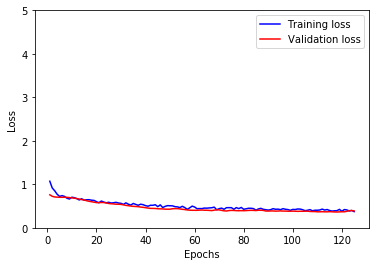

Validation accuracy: 0.8571428453529274


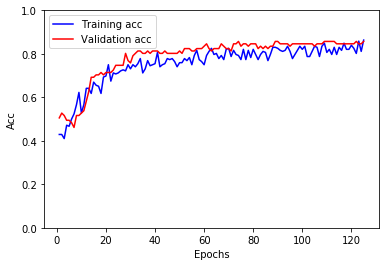

In [309]:
acc_values = history['acc']
val_acc_values = history['val_acc']
loss_values = history['loss']
val_loss_values = history['val_loss']
epochs = range(1, len(loss_values) + 1)

print("Validation loss: {0}".format(val_loss_values[-1]))
plt.figure()
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend()
plt.show()

print("Validation accuracy: {0}".format(val_acc_values[-1]))
plt.figure()
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Confusion matrix and classification report
As this is a medical classification problem, accuracy might not be the most important metric. So here is the confusion matrix and classification report for the whole set, which gives us a bit more information than just the accuracy.

In [310]:
data = dataframe.loc[:, 'age':'thal']
labels = dataframe.loc[:, 'num']
predicts = model.predict(data)

# Round the probabilities to the neares integer
y_pred = np.rint(predicts)
cm = confusion_matrix(labels, y_pred)

print("Confusion matrix:\n",cm)

accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
print("Accuracy calculated from the training set = %.3f" % (accuracy))

print(classification_report(labels, y_pred,
                            target_names=["normal (negative)","disease (positive)"]))

Confusion matrix:
 [[153  11]
 [ 32 107]]
Accuracy calculated from the training set = 0.858
                    precision    recall  f1-score   support

 normal (negative)       0.83      0.93      0.88       164
disease (positive)       0.91      0.77      0.83       139

         micro avg       0.86      0.86      0.86       303
         macro avg       0.87      0.85      0.85       303
      weighted avg       0.86      0.86      0.86       303




# 8. Conclusion

Because the data set is relatively small, the results for individual compilations and trainings vary alot. Also luck in the data shuffling affects the results. From the confusion matrix above, we can see that this run in particular had a lot of false negatives (32), which is really bad in health screening, because all those were heart diseases that would not have been noticed. Overall this network, with the provided data, cannot predict heart disease very accurately.